# MetroTransit Passenger Trends
## Key questions:
1. What are the most popular MetroTransit stations, as defined by volume of "Ons" & "Offs"?
2. What part of the week sees the highest level of MetroTransit traffic?
3. What is the relationship between station "Ons" & "Offs"?
4. How has Minnesota's lockdown impacted MetroTransit?

In [1]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gmaps


import requests
import time
from scipy.stats import linregress
import json
# Import API key
# Google developer API key
# from config import gkey


# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy


# Save file path to variable
metrotransit_csv = "Resources/TransitStopsBoardingsAndAlightings2019.csv"

# Read with Pandas
metrotransit_df = pd.read_csv(metrotransit_csv)
metrotransit_df.head()

,Provider,Route Type,Route Classification,Route,Dir,Site_id,Geo_Node_Name,Group ID,latitude,longitude,...,City,Trips,Obs Trips,Schedule,Ons,Offs,Seq,%Sampled,Downtown,Comment
0,Metro Transit,Urban Local,Core Local,2,East,51581.0,HENNEPIN AVE & FRANKLIN AVE / 22ND ST,NaN,44.961886,-93.292079,...,MINNEAPOLIS,92.0,92.0,Weekday,75,8.0,1.0,100%,N,NaN
1,Metro Transit,Urban Local,Core Local,2,East,1099.0,HENNEPIN AVE S & 22ND ST W,NaN,44.961030,-93.292777,...,MINNEAPOLIS,92.0,92.0,Weekday,33,2.0,2.0,100%,N,NaN
2,Metro Transit,Urban Local,Core Local,2,East,13340.0,DUPONT AVE & FRANKLIN AVE W,NaN,44.962534,-93.293016,...,MINNEAPOLIS,92.0,92.0,Weekday,17,1.0,3.0,100%,N,NaN
3,Metro Transit,Urban Local,Core Local,2,East,13337.0,FRANKLIN AVE W & HENNEPIN AVE S,NaN,44.962630,-93.291123,...,MINNEAPOLIS,92.0,92.0,Weekday,177,2.0,4.0,100%,N,NaN
4,Metro Transit,Urban Local,Core Local,2,East,56705.0,FRANKLIN AVE W & LYNDALE AVE S,NaN,44.962642,-93.287697,...,MINNEAPOLIS,92.0,92.0,Weekday,143,4.0,5.0,100%,N,NaN


In [2]:
#establish DF's
Route_df = metrotransit_df.groupby("Route Type")
Route_df=Route_df.count()
site_route_df = metrotransit_df.groupby("Site_id")
site_route_df.head()

metrotransit_df["Site_id"].nunique()

metrotransit_df["Schedule"].unique()
Route_df.head()

core_local_df = metrotransit_df.loc[metrotransit_df["Route Classification"]=="Core Local"]
core_local_df

,Provider,Route Type,Route Classification,Route,Dir,Site_id,Geo_Node_Name,Group ID,latitude,longitude,...,City,Trips,Obs Trips,Schedule,Ons,Offs,Seq,%Sampled,Downtown,Comment
0,Metro Transit,Urban Local,Core Local,2,East,51581.0,HENNEPIN AVE & FRANKLIN AVE / 22ND ST,NaN,44.961886,-93.292079,...,MINNEAPOLIS,92.0,92.0,Weekday,75,8.0,1.0,100%,N,NaN
1,Metro Transit,Urban Local,Core Local,2,East,1099.0,HENNEPIN AVE S & 22ND ST W,NaN,44.961030,-93.292777,...,MINNEAPOLIS,92.0,92.0,Weekday,33,2.0,2.0,100%,N,NaN
2,Metro Transit,Urban Local,Core Local,2,East,13340.0,DUPONT AVE & FRANKLIN AVE W,NaN,44.962534,-93.293016,...,MINNEAPOLIS,92.0,92.0,Weekday,17,1.0,3.0,100%,N,NaN
3,Metro Transit,Urban Local,Core Local,2,East,13337.0,FRANKLIN AVE W & HENNEPIN AVE S,NaN,44.962630,-93.291123,...,MINNEAPOLIS,92.0,92.0,Weekday,177,2.0,4.0,100%,N,NaN
4,Metro Transit,Urban Local,Core Local,2,East,56705.0,FRANKLIN AVE W & LYNDALE AVE S,NaN,44.962642,-93.287697,...,MINNEAPOLIS,92.0,92.0,Weekday,143,4.0,5.0,100%,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37147,Metro Transit,Urban Local,Core Local,74,West,56128.0,46TH ST & 46TH AVE STATION,NaN,44.919824,-93.208186,...,MINNEAPOLIS,37.0,37.0,Sunday,2,6.0,136.0,100%,N,NaN
37148,Metro Transit,Urban Local,Core Local,74,West,51515.0,46TH ST E & 42ND AVE S,NaN,44.919800,-93.212600,...,MINNEAPOLIS,37.0,37.0,Sunday,0,2.0,137.0,100%,N,NaN
37149,Metro Transit,Urban Local,Core Local,74,West,16607.0,46TH ST & MINNEHAHA STATION,NaN,44.919763,-93.215446,...,MINNEAPOLIS,37.0,37.0,Sunday,0,8.0,138.0,100%,N,NaN
37150,Metro Transit,Urban Local,Core Local,74,West,50743.0,46TH ST E & SNELLING AVE,NaN,44.919748,-93.216365,...,MINNEAPOLIS,37.0,37.0,Sunday,2,10.0,139.0,100%,N,NaN


In [16]:
#number of stops
core_local_df['Geo_Node_Name'].nunique()

3975

C:\ProgramData\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.


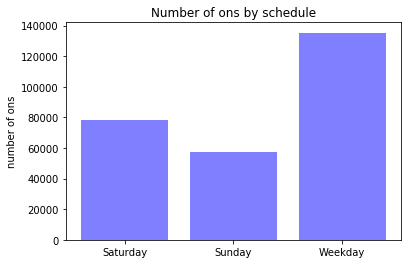

In [3]:
#Bar chart showing Number of ons based on the Schedule
schedule=core_local_df["Ons"].astype(float)
core_local_df["Ons"]=schedule

schedule_df = core_local_df.groupby("Schedule").sum()

schedule_df=schedule_df.reset_index()

bar_data=core_local_df

x_axis=schedule_df["Schedule"]
ons=schedule_df["Ons"]




plt.bar(x_axis, ons, color=('B'), alpha=0.5, align="center")
plt.title("Number of ons by schedule")
plt.ylabel("number of ons")

plt.savefig("../KD/ImagesKD/Bar-by-schedule.png")

In [4]:
#create DF grouped by Schedule

schedule_df = core_local_df.groupby("Schedule")
schedule_df=schedule_df.count()


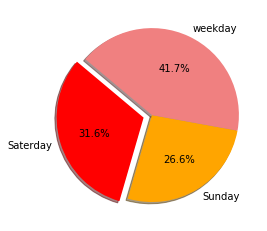

In [5]:
#Pie plot of on by schedule

explode = (0.1,0,0,0)
colors = ["red", "orange", "lightcoral", "lightskyblue"]
x_axis=schedule_df
ons=schedule_df["Ons"].astype(float)
labels=["Saterday","Sunday","weekday"]
figpie=plt.pie(ons, labels= labels , colors=colors,
        autopct="%1.1f%%",explode = (0.1,0,0), shadow=True, startangle=140)

plt.savefig("../KD/ImagesKD/Pie3-by-schedule.png")
plt.show()

In [6]:
#Display the DF grouped by Schedule


sched_df=core_local_df.groupby("Schedule")
sched_df.count()

,Provider,Route Type,Route Classification,Route,Dir,Site_id,Geo_Node_Name,Group ID,latitude,longitude,...,y-coordinate,City,Trips,Obs Trips,Ons,Offs,Seq,%Sampled,Downtown,Comment
Schedule,,,,,,,,,,,,,,,,,,,,,
Saturday,5738,5738,5738,5738,5738,5738,5738,72,5738,5738,...,5738,5738,5738,5738,5738,5738,5738,5738,5738,81
Sunday,4831,4831,4831,4831,4831,4831,4831,65,4831,4831,...,4831,4831,4831,4831,4831,4831,4831,4831,4831,56
Weekday,7574,7574,7574,7574,7574,7574,7574,91,7574,7574,...,7574,7574,7574,7574,7574,7574,7574,7574,7574,126


In [7]:
#all days



# Store latitude and longitude in locations
locations = core_local_df[["latitude", "longitude"]]
ons = core_local_df["Ons"].astype(float)


# Plot Heatmap
fig_all = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=ons, 
                                 dissipating=False, max_intensity=10,
                                 point_radius=.001)


# Add layer
fig_all.add_layer(heat_layer)

# Display figure
fig_all

#Save PNG
#plt.savefig("../KD/ImagesKD/All-Gmap.png")


Figure(layout=FigureLayout(height='420px'))

In [12]:
#Weekdays
weekday_df = core_local_df.loc[core_local_df["Schedule"]=="Weekday"]
weekday_df


# Store latitude and longitude in locations
locations = weekday_df[["latitude", "longitude"]]
ons = weekday_df["Ons"].astype(float)


# Plot Heatmap
fig_weekdays = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=ons, 
                                 dissipating=False, max_intensity=10,
                                 point_radius=.001)


# Add layer
fig_weekdays.add_layer(heat_layer)

# Display figure
fig_weekdays


#top 5 weekdays

weekday_df['Ons'] = weekday_df["Ons"].astype(float)
weekday_top5ons = weekday_df.nlargest(5,["Ons"])
weekday_top5ons

# Pins on the map to answer what are the most popular "ons" & "offs"

info_box_template = """
<dl>
<dt>Name</dt><dd>{Geo_Node_Name}</dd>
<dt>Ons</dt><dd>{Ons}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
weekdays_top5_ons_df = [info_box_template.format(**row) for index, row in weekday_top5ons.iterrows()]
weekdays_top5_ons_pins = weekday_top5ons[["latitude", "longitude"]]


# Add marker layer ontop of heat map
# Assign the marker layer to a variable
markers = gmaps.marker_layer(weekdays_top5_ons_pins,info_box_content=weekdays_top5_ons_df)
# Add the layer to the map
fig_weekdays.add_layer(markers)

# Display figure
fig_weekdays




#Save PNG
# plt.savefig("../KD/ImagesKD/Weekdays-Gmap.png")
# fig_weekdays

C:\ProgramData\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Figure(layout=FigureLayout(height='420px'))

In [13]:
#Saturday
sat_df = core_local_df.loc[core_local_df["Schedule"]=="Saturday"]
sat_df


# Store latitude and longitude in locations 
locations = sat_df[["latitude", "longitude"]]
ons = sat_df["Ons"].astype(float)


# Plot Heatmap
fig_sat = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=ons, 
                                 dissipating=False, max_intensity=10,
                                 point_radius=.001)


# Add layer
fig_sat.add_layer(heat_layer)

# Display figure
fig_sat

#top 5 Saturdays
sat_df['Ons'] = sat_df["Ons"].astype(float)

sat_top5ons = sat_df.nlargest(5,["Ons"])
sat_top5ons

# Pins on the map to answer what are the most popular "ons" & "offs"

info_box_template = """
<dl>
<dt>Name</dt><dd>{Geo_Node_Name}</dd>
<dt>Ons</dt><dd>{Ons}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
sat_top5_ons_df = [info_box_template.format(**row) for index, row in sat_top5ons.iterrows()]
sat_top5_ons_pins = sat_top5ons[["latitude", "longitude"]]


# Add marker layer ontop of heat map
# Assign the marker layer to a variable
markers = gmaps.marker_layer(sat_top5_ons_pins,info_box_content=sat_top5_ons_df)
# Add the layer to the map
fig_sat.add_layer(markers)

fig_sat

#Save PNG
# plt.savefig("../KD/ImagesKD/Sat-Gmap.png")
# fig_sat

C:\ProgramData\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Figure(layout=FigureLayout(height='420px'))

In [14]:
#Sundays

sun_df = core_local_df.loc[core_local_df["Schedule"]=="Sunday"]
sun_df


# Store latitude and longitude in locations
locations = sun_df[["latitude", "longitude"]]
ons = sun_df["Ons"].astype(float)


# Plot Heatmap
fig_sun = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=ons, 
                                 dissipating=False, max_intensity=10,
                                 point_radius=.001)


# Add layer
fig_sun.add_layer(heat_layer)

# Display figure
fig_sun


#top 5 Sundays
sun_df['Ons'] = sun_df["Ons"].astype(float)

sun_top5ons = sun_df.nlargest(5,["Ons"])
sun_top5ons



# Pins on the map to answer what are the most popular "ons" & "offs"

info_box_template = """
<dl>
<dt>Name</dt><dd>{Geo_Node_Name}</dd>
<dt>Ons</dt><dd>{Ons}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
sun_top5_ons_df = [info_box_template.format(**row) for index, row in sun_top5ons.iterrows()]
sun_top5_ons_pins = sun_top5ons[["latitude", "longitude"]]


# Add marker layer ontop of heat map
# Assign the marker layer to a variable
markers = gmaps.marker_layer(sun_top5_ons_pins,info_box_content=sun_top5_ons_df)
# Add the layer to the map
fig_sun.add_layer(markers)

fig_sun
#Save PNG
# plt.savefig("../KD/ImagesKD/Sun-Gmap.png")
# fig_sun

C:\ProgramData\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Figure(layout=FigureLayout(height='420px'))